# Fine Tune Transformers from HuggingFace MiniLM

**Note: This notebook is run in Paperspace platform**

In [1]:
%pip install transformers
%pip install torch
%pip install imblearn
%pip install wandb --upgrade


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 20.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.13.4
    Uninstalling wandb-0.13.4:
      Successfully uninstalled wandb-0.13.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_40/491656687.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


## Import Clean Text Data

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('data_clean_with_stopword_short.csv', encoding='utf8')                                            
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112247 non-null  int64 
 1   text    112247 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      5375
Name: label, dtype: int64

## Define pretrained tokenizer and model

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess data and Fine Tune Transformers

In [7]:
# Data: Text Input and Label 
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


# Create torch dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


# Define Trainer parameters 
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    
    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    
    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy, 
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


# Plot Confusion Matrix 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


# Run cross-validation 
def run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False):
    
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=epoch,
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )

        if n_fold <= 4:
            checkpoint_temp = True
        else:
            checkpoint_temp = False

        trainer.train(resume_from_checkpoint=checkpoint)  # Add gradient_clip_val
        print("Complete for fold", n_fold)
        n_fold = n_fold + 1



# Run Hold Out Test 

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1127)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='MiniLM',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    args=args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [8]:
# Predict (Hold Out Test) 

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='MiniLM',
                            model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-3820', 
                            average_method='binary',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(8,5), 
                        cbar=True, 
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection', 
                        cmap='YlGnBu', 
                        sum_stats=False)



## Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: MiniLM


0it [00:00, ?it/s]

Running for Fold:  1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.106800,0.110836,0.966414,0.706941,0.511152,0.593312,0.975729,0.989333,0.982484,0.841335,0.750243,0.787898
2,0.095700,0.106817,0.967751,0.745810,0.496283,0.595982,0.975062,0.991485,0.983205,0.860436,0.743884,0.789594
3,0.065200,0.115484,0.966592,0.679912,0.572491,0.621594,0.978648,0.986432,0.982525,0.829280,0.779461,0.802060
4,0.052100,0.150957,0.966325,0.676211,0.570632,0.618952,0.978554,0.986245,0.982384,0.827382,0.778438,0.800668


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-12628/py

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.089200,0.089264,0.974343,0.794811,0.626394,0.700624,0.981391,0.991859,0.986597,0.888101,0.809127,0.843610
2,0.068600,0.093926,0.972829,0.737271,0.672862,0.703596,0.983604,0.987929,0.985762,0.860437,0.830396,0.844679
3,0.051000,0.099761,0.974610,0.767442,0.674721,0.718101,0.983724,0.989707,0.986706,0.875583,0.832214,0.852404
4,0.030900,0.120961,0.974343,0.769397,0.663569,0.712575,0.983180,0.989988,0.986572,0.876288,0.826778,0.849574


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-12628/py

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.075500,0.067614,0.981292,0.837449,0.756506,0.794922,0.987801,0.992608,0.990199,0.912625,0.874557,0.892560
2,0.049200,0.083129,0.980935,0.866516,0.711896,0.781633,0.985626,0.994479,0.990033,0.926071,0.853188,0.885833
3,0.047900,0.087011,0.981915,0.845361,0.762082,0.801564,0.988082,0.992982,0.990526,0.916721,0.877532,0.896045
4,0.031500,0.094475,0.981203,0.828974,0.765799,0.796135,0.988255,0.992046,0.990147,0.908614,0.878923,0.893141


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-12628/py

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.055600,0.057512,0.982806,0.870968,0.752788,0.807577,0.987639,0.994386,0.991001,0.929304,0.873587,0.899289
2,0.052300,0.060566,0.984321,0.854902,0.810409,0.832061,0.990481,0.993076,0.991776,0.922691,0.901742,0.911919
3,0.033900,0.067201,0.984232,0.870637,0.788104,0.827317,0.989383,0.994105,0.991739,0.930010,0.891105,0.909528
4,0.024600,0.071055,0.983430,0.842412,0.804833,0.823194,0.990197,0.992421,0.991308,0.916305,0.898627,0.907251


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-12628/py

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.053800,0.058079,0.983786,0.899103,0.745353,0.815041,0.987290,0.995789,0.991521,0.943197,0.870571,0.903281
2,0.047000,0.064435,0.984143,0.843511,0.821561,0.832392,0.991029,0.992327,0.991678,0.917270,0.906944,0.912035
3,0.028200,0.072401,0.984677,0.878099,0.789963,0.831703,0.989480,0.994479,0.991973,0.933789,0.892221,0.911838
4,0.024900,0.071215,0.984855,0.859375,0.817844,0.838095,0.990852,0.993263,0.992056,0.925114,0.905553,0.915076


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-12628/py

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [10]:
run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: MiniLM


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-12628 (score: 0.10681725293397903).


Epoch,Training Loss,Validation Loss


1it [00:08,  8.77s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6314 (score: 0.08926379680633545).


Epoch,Training Loss,Validation Loss


2it [00:19, 10.04s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6314 (score: 0.06761439144611359).


Epoch,Training Loss,Validation Loss


3it [00:30, 10.29s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6314 (score: 0.05751248449087143).


Epoch,Training Loss,Validation Loss


4it [00:43, 11.40s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6314 (score: 0.05807929113507271).


Epoch,Training Loss,Validation Loss


5it [00:54, 10.86s/it]


Complete for fold 5


## Hold Out Split

In [11]:
#holdout
run_hold_out_split(model_name='MiniLM',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Developing Model with Hold Out Splits for: MiniLM


/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.046500,0.074591,0.984232,0.896703,0.758364,0.821752,0.987929,0.995602,0.991751,0.942316,0.876983,0.906752
2,0.036600,0.073005,0.985835,0.911063,0.780669,0.840841,0.989038,0.996164,0.992588,0.950050,0.888416,0.916714
3,0.030200,0.068120,0.985657,0.880808,0.810409,0.844143,0.990494,0.994479,0.992483,0.935651,0.902444,0.918313
4,0.022900,0.075143,0.985924,0.900844,0.793680,0.843874,0.989675,0.995602,0.992630,0.945260,0.894641,0.918252


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpo

Complete for hold-out validate set


In [12]:
#holdout
run_hold_out_split(model_name='MiniLM',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-25256.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25256
  Continuing training from checkpoint, will skip to sav

Developing Model with Hold Out Splits for: MiniLM


0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-18942 (score: 0.068120077252388).


Epoch,Training Loss,Validation Loss


Complete for hold-out validate set


### Test Split Confusion Matrix

#### Epoch 1

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314/pytorc

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10687
           1       0.90      0.76      0.82       538

    accuracy                           0.98     11225
   macro avg       0.94      0.88      0.91     11225
weighted avg       0.98      0.98      0.98     11225


Label 1: Cyberbullying
Precision:  0.8967032967032967
Recall:  0.758364312267658
F-measure:  0.8217522658610271

Label 0: Non-Cyberbullying
Precision:  0.9879294336118849
Recall:  0.9956021334331431
F-measure:  0.9917509437479611

Macro Metrics
Precision:  0.9423163651575908
Recall:  0.8769832228504005
F-measure:  0.9067516048044941



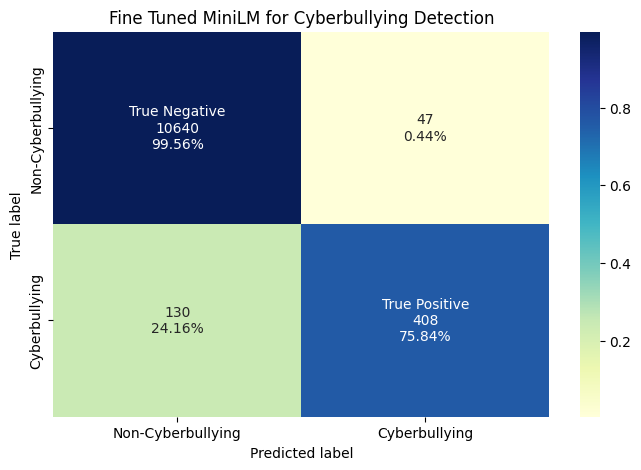

In [14]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6314', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10687
           1       0.91      0.78      0.84       538

    accuracy                           0.99     11225
   macro avg       0.95      0.89      0.92     11225
weighted avg       0.99      0.99      0.99     11225


Label 1: Cyberbullying
Precision:  0.911062906724512
Recall:  0.7806691449814126
F-measure:  0.8408408408408409

Label 0: Non-Cyberbullying
Precision:  0.9890375325157934
Recall:  0.9961635632076354
F-measure:  0.9925877581464734

Macro Metrics
Precision:  0.9500502196201527
Recall:  0.888416354094524
F-measure:  0.9167142994936571



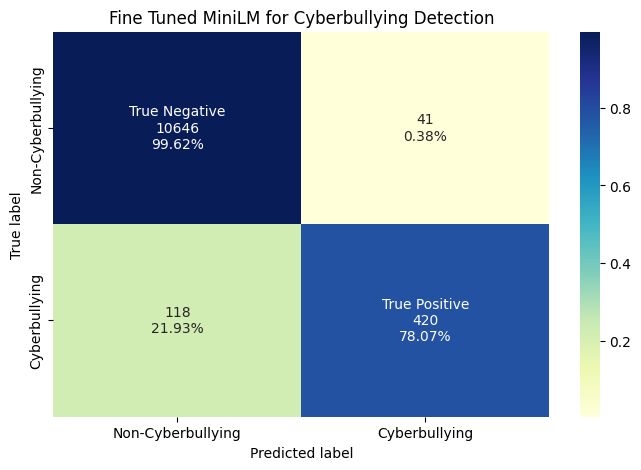

In [16]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-12628', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-18942/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-18942",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-18942/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.88      0.81      0.84       538

    accuracy                           0.99     11225
   macro avg       0.94      0.90      0.92     11225
weighted avg       0.99      0.99      0.99     11225


Label 1: Cyberbullying
Precision:  0.8808080808080808
Recall:  0.8104089219330854
F-measure:  0.8441432720232331

Label 0: Non-Cyberbullying
Precision:  0.9904939422180802
Recall:  0.9944792738841584
F-measure:  0.992482607274595

Macro Metrics
Precision:  0.9356510115130805
Recall:  0.9024440979086219
F-measure:  0.918312939648914



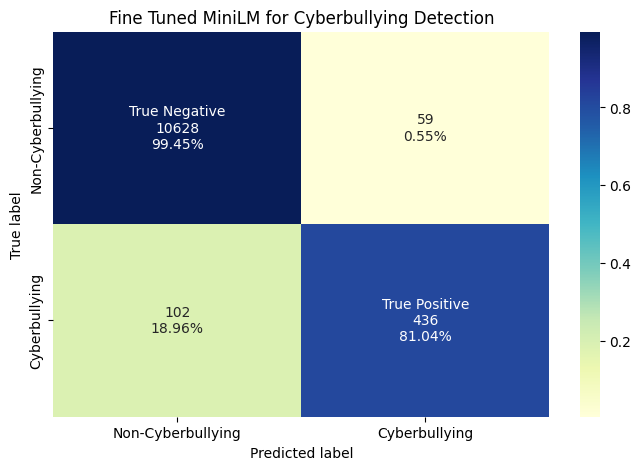

In [17]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-18942', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-25256/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-25256",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-25256/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10687
           1       0.90      0.79      0.84       538

    accuracy                           0.99     11225
   macro avg       0.95      0.89      0.92     11225
weighted avg       0.99      0.99      0.99     11225


Label 1: Cyberbullying
Precision:  0.9008438818565401
Recall:  0.7936802973977695
F-measure:  0.8438735177865613

Label 0: Non-Cyberbullying
Precision:  0.9896753790345084
Recall:  0.9956021334331431
F-measure:  0.9926299095064839

Macro Metrics
Precision:  0.9452596304455243
Recall:  0.8946412154154563
F-measure:  0.9182517136465226



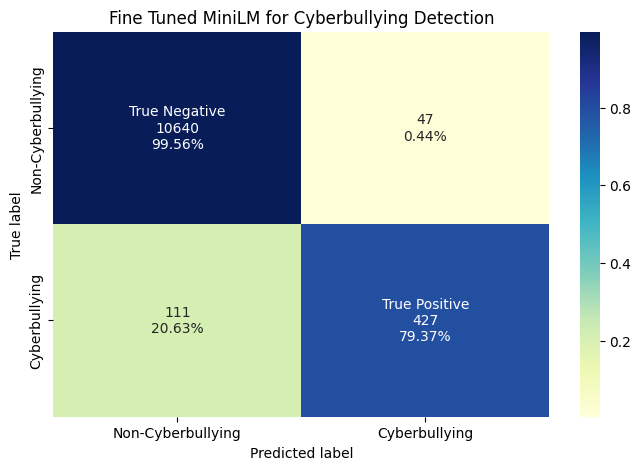

In [15]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-25256', 
                        average_method='binary',
                        X_test=X_test)